In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, json, time
import re
import pandas as pd
import numpy as np
np.random.seed(0)

import torch
torch.random.manual_seed(0)

import warnings
warnings.filterwarnings('ignore')

data_path = "" # directory to the data folder

Mounted at /content/drive


In [ ]:
csv_file_path = os.path.join(data_path, "Hotel_Reviews.csv")

df = pd.read_csv(csv_file_path)
df.head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968


In [ ]:
uk_df = df[(df['Hotel_Address'].str.contains("United Kingdom"))\
           & (df['Reviewer_Nationality'].str.contains("United Kingdom"))
           ]
uk_df.reset_index(drop=True, inplace=True)
print(df.shape, uk_df.shape)

(515738, 17) (170649, 17)


In [ ]:
uk_df['Postal_Code'] = uk_df['Hotel_Address'].apply(lambda x: " ".join(x.split(" ")[-4:-2]))
uk_df['City'] = uk_df['Hotel_Address'].apply(lambda x: x.split(" ")[-5])

def clean_tag(tag):
    pattern = r"[\'\[\]\,]"
    clean_tag = re.sub(pattern, "", tag).strip(" ")
    clean_tag = re.sub(r" {3}", ",", clean_tag)
    return ", ".join(clean_tag.split(','))

uk_df['Clean_Tags'] = uk_df['Tags'].apply(clean_tag)


take_cols = [
    'Hotel_Name', 'Average_Score',
    'Positive_Review', 'Negative_Review', 'Review_Date',
    'Hotel_Address', 'Postal_Code', 'City', 'lat', 'lng',
    'Reviewer_Score', 'Clean_Tags',
    ]
uk_df = uk_df[take_cols]
uk_df.head()

,Hotel_Name,Average_Score,Positive_Review,Negative_Review,Review_Date,Hotel_Address,Postal_Code,City,lat,lng,Reviewer_Score,Clean_Tags
0,K K Hotel George,8.5,Fantastic location very clean room someone ca...,Room wasn t ready on arrival after travelling...,6/30/2017,1 15 Templeton Place Earl s Court Kensington a...,SW5 9NB,London,51.491888,-0.194971,5.8,"Leisure trip, Couple, Classic Double Room, Sta..."
1,K K Hotel George,8.5,Breakfast was excellent Staff in the restaura...,Our room allocated wasn t up to our expectati...,6/27/2017,1 15 Templeton Place Earl s Court Kensington a...,SW5 9NB,London,51.491888,-0.194971,6.7,"Leisure trip, Group, Classic Triple Room, Stay..."
2,K K Hotel George,8.5,The garden was a bonus Lovely area to have so...,The cooked elements of breakfast could have b...,6/27/2017,1 15 Templeton Place Earl s Court Kensington a...,SW5 9NB,London,51.491888,-0.194971,8.3,"Leisure trip, Couple, Classic Double Room, Sta..."
3,K K Hotel George,8.5,Great location it s easy to find and incredib...,The room was a lot smaller than advertised I ...,6/25/2017,1 15 Templeton Place Earl s Court Kensington a...,SW5 9NB,London,51.491888,-0.194971,7.1,"Leisure trip, Solo traveler, Classic Double Ro..."
4,K K Hotel George,8.5,Location first and foremost Lovely gardens,Lower ground floor room L01 possibly the smal...,6/25/2017,1 15 Templeton Place Earl s Court Kensington a...,SW5 9NB,London,51.491888,-0.194971,5.0,"Leisure trip, Couple, Classic Double Room, Sta..."


<Axes: xlabel='Reviewer_Score', ylabel='Count'>

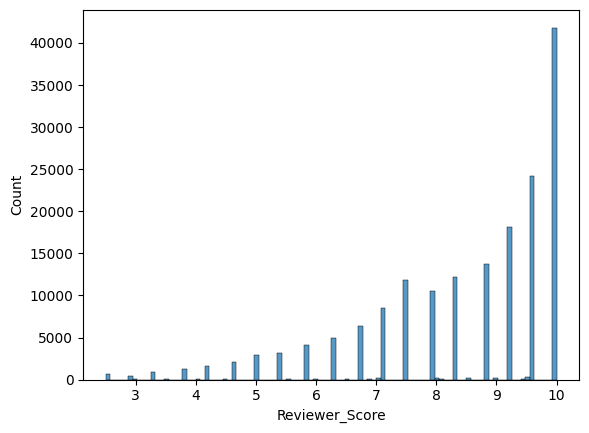

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(uk_df['Reviewer_Score'])

The reviewer score mean is 8. Therefore, we will only consider the reviews from reviewer score > 8.

In [ ]:
uk_df['Reviewer_Score'].mean()

8.42427438777842

In [ ]:
uk_df = uk_df[uk_df['Reviewer_Score'] >= 8]
print(uk_df.shape)

(110856, 12)


In [ ]:
agg_uk_df = uk_df.groupby('Hotel_Name').agg(
    {
        'Average_Score': 'first',
        'Hotel_Address': 'first',
        'Review_Date': 'first',
        'Hotel_Address': 'first',
        'Postal_Code': 'first',
        'City': 'first',
        'lat': 'first',
        'lng': 'first',
        'Clean_Tags': 'first',
     }
).reset_index()

In [ ]:
agg_uk_df.head()

,Hotel_Name,Average_Score,Hotel_Address,Review_Date,Postal_Code,City,lat,lng,Clean_Tags
0,11 Cadogan Gardens,8.7,11 Cadogan Gardens Sloane Square Kensington an...,8/3/2017,SW3 2RJ,London,51.493616,-0.159235,"Leisure trip, Couple, Superior Queen Room, Sta..."
1,41,9.6,41 Buckingham Palace Road Westminster Borough ...,5/25/2017,SW1W 0PS,London,51.498147,-0.143649,"Leisure trip, Couple, Executive King Room with..."
2,45 Park Lane Dorchester Collection,9.4,45 Park Lane Westminster Borough London W1K 1P...,2/21/2017,W1K 1PN,London,51.506371,-0.151536,"Leisure trip, Solo traveler, Executive Queen R..."
3,88 Studios,8.4,88 Holland Road Kensington and Chelsea London ...,8/2/2017,W14 8BN,London,51.499279,-0.209073,"Leisure trip, Family with young children, Fami..."
4,Ace Hotel London Shoreditch,8.6,100 Shoreditch High Street Hackney London E1 6...,8/2/2017,E1 6JQ,London,51.525416,-0.077285,"Leisure trip, Solo traveler, Standard Double R..."


In [ ]:
review_dct = dict(Hotel_Name=[], Positive_Review=[], Negative_Review=[])

excl_reviews = ["no negative", "no positive", "none", "nothing", "n a", "na"]

n_review = 3
for hotel_name in agg_uk_df['Hotel_Name']:
    review_dct['Hotel_Name'].append(hotel_name)
    for col in ['Positive_Review', 'Negative_Review']:
        reviews = uk_df[uk_df['Hotel_Name'] == hotel_name][col].values
        review = []
        for text in reviews:
            if text.lower() in excl_reviews: continue
            review.append(text.strip())

            if len(review) == n_review: break

        review_dct[col].append(", ".join(review))

In [ ]:
review_df = pd.DataFrame(review_dct)

final_df = pd.merge(left=agg_uk_df, right=review_df,
                    on="Hotel_Name", how='left')

In [ ]:
final_df.head()

,Hotel_Name,Average_Score,Hotel_Address,Review_Date,Postal_Code,City,lat,lng,Clean_Tags,Positive_Review,Negative_Review
0,11 Cadogan Gardens,8.7,11 Cadogan Gardens Sloane Square Kensington an...,8/3/2017,SW3 2RJ,London,51.493616,-0.159235,"Leisure trip, Couple, Superior Queen Room, Sta...",We were particularly impressed by the very war...,Thought the prise of drinks at the bar a littl...
1,41,9.6,41 Buckingham Palace Road Westminster Borough ...,5/25/2017,SW1W 0PS,London,51.498147,-0.143649,"Leisure trip, Couple, Executive King Room with...",Amazing attention to detail Our stay was made ...,"Minimal wifi in the bedroom, Nothing everythin..."
2,45 Park Lane Dorchester Collection,9.4,45 Park Lane Westminster Borough London W1K 1P...,2/21/2017,W1K 1PN,London,51.506371,-0.151536,"Leisure trip, Solo traveler, Executive Queen R...",Everything here are almost perfect the staffs ...,More kinds of fruit juice will make the mini b...
3,88 Studios,8.4,88 Holland Road Kensington and Chelsea London ...,8/2/2017,W14 8BN,London,51.499279,-0.209073,"Leisure trip, Family with young children, Fami...",It was a very nice apartment and the customer ...,Maybe more selection of tea coffee hot chocola...
4,Ace Hotel London Shoreditch,8.6,100 Shoreditch High Street Hackney London E1 6...,8/2/2017,E1 6JQ,London,51.525416,-0.077285,"Leisure trip, Solo traveler, Standard Double R...",Effective security staff on the front door aft...,There was a heavy downpour I had to queue and ...


In [ ]:
final_df.shape

(400, 11)

In [ ]:
final_df.to_csv(os.path.join(data_path, "uk_final_df.csv"),
                 index=False)